In [7]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import io, s3fs, json, traceback
pd.set_option('display.max_columns', None)
print('Program run at', dt.now())
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split as tts


Program run at 2021-06-15 17:13:13.185957


In [8]:
df = pd.read_csv('s3://bleeding-hearts/workingdata/est_rmv.csv')
df.drop(columns=['Unnamed: 0'],inplace=True)
repl = {'Very Low': 0,
       'Low': 1,
       'Moderate': 2,
       'High': 3,
       'Very High': 4}
df['Child Opportunity Levels, overall COI, nationally-normed'] = df['Child Opportunity Levels, overall COI, nationally-normed'].replace(repl)
X = df.loc[:, df.columns != 'Child Opportunity Levels, overall COI, nationally-normed']
y = df['Child Opportunity Levels, overall COI, nationally-normed']

In [12]:
X_train, X_test, y_train, y_test = tts(X, y, test_size=.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(14566, 63) (14566,)
(3642, 63) (3642,)


In [10]:
import logging
import numpy as np
from optparse import OptionParser
import sys
from time import time
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics


# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

op = OptionParser()
op.add_option("--report",
              action="store_true", dest="print_report",
              help="Print a detailed classification report.")
op.add_option("--chi2_select",
              action="store", type="int", dest="select_chi2",
              help="Select some number of features using a chi-squared test")
op.add_option("--confusion_matrix",
              action="store_true", dest="print_cm",
              help="Print the confusion matrix.")
op.add_option("--top10",
              action="store_true", dest="print_top10",
              help="Print ten most discriminative terms per class"
                   " for every classifier.")
op.add_option("--all_categories",
              action="store_true", dest="all_categories",
              help="Whether to use all categories or not.")
op.add_option("--use_hashing",
              action="store_true",
              help="Use a hashing vectorizer.")
op.add_option("--n_features",
              action="store", type=int, default=2 ** 16,
              help="n_features when using the hashing vectorizer.")
op.add_option("--filtered",
              action="store_true",
              help="Remove newsgroup information that is easily overfit: "
                   "headers, signatures, and quoting.")


def is_interactive():
    return not hasattr(sys.modules['__main__'], '__file__')


# work-around for Jupyter notebook and IPython console
argv = [] if is_interactive() else sys.argv[1:]
(opts, args) = op.parse_args(argv)
if len(args) > 0:
    op.error("this script takes no arguments.")
    sys.exit(1)

print(__doc__)
op.print_help()
print()

Automatically created module for IPython interactive environment
Usage: ipykernel_launcher.py [options]

Options:
  -h, --help            show this help message and exit
  --report              Print a detailed classification report.
  --chi2_select=SELECT_CHI2
                        Select some number of features using a chi-squared
                        test
  --confusion_matrix    Print the confusion matrix.
  --top10               Print ten most discriminative terms per class for
                        every classifier.
  --all_categories      Whether to use all categories or not.
  --use_hashing         Use a hashing vectorizer.
  --n_features=N_FEATURES
                        n_features when using the hashing vectorizer.
  --filtered            Remove newsgroup information that is easily overfit:
                        headers, signatures, and quoting.



In [13]:
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

        if opts.print_top10 and feature_names is not None:
            print("top 10 keywords per class:")
            for i, label in enumerate(target_names):
                top10 = np.argsort(clf.coef_[i])[-10:]
                print(trim("%s: %s" % (label, " ".join(feature_names[top10]))))
        print()

    if opts.print_report:
        print("classification report:")
        print(metrics.classification_report(y_test, pred,
                                            target_names=target_names))

    if opts.print_cm:
        print("confusion matrix:")
        print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time


results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),
        (Perceptron(max_iter=50), "Perceptron"),
        (PassiveAggressiveClassifier(max_iter=50),
         "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(penalty=penalty, dual=False,
                                       tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                           penalty=penalty)))

# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                       penalty="elasticnet")))

# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))
results.append(benchmark(ComplementNB(alpha=.1)))

print('=' * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,
                                                  tol=1e-3))),
  ('classification', LinearSVC(penalty="l2"))])))

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(solver='sag', tol=0.01)
train time: 3.831s
test time:  0.006s
accuracy:   0.258
dimensionality: 63
density: 1.000000


Perceptron
________________________________________________________________________________
Training: 
Perceptron(max_iter=50)
train time: 0.141s
test time:  0.003s
accuracy:   0.217
dimensionality: 63
density: 1.000000


Passive-Aggressive
________________________________________________________________________________
Training: 
PassiveAggressiveClassifier(max_iter=50)
train time: 0.175s
test time:  0.003s
accuracy:   0.177
dimensionality: 63
density: 1.000000


kNN
________________________________________________________________________________
Training: 
KNeighborsClassifier(n_neighbors=10)
train time: 0.043s
test time:  0.204s
accuracy:   0.566

Random forest
________________________________________________________________________________
Tr

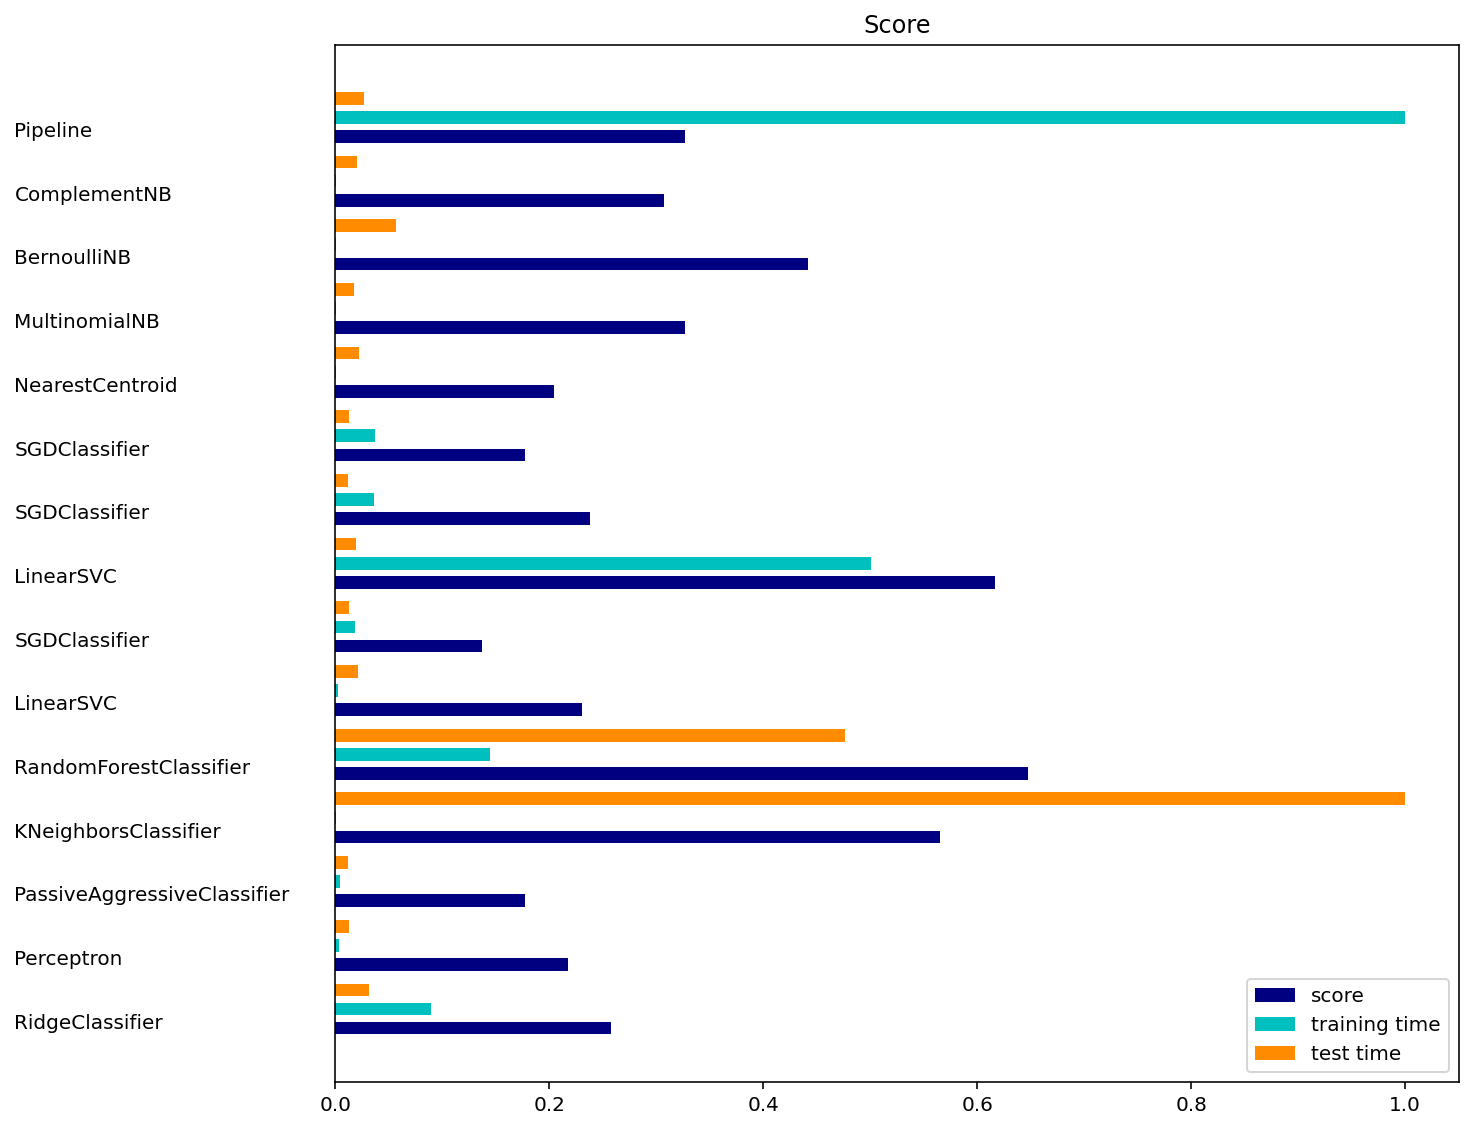

In [14]:
indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()